# Análise de Integridade e Qualidade dos Dados (Camada Bronze)
Esta etapa consiste na análise do dado bruto (Raw Data) para identificar a "saúde" da base de dados antes de qualquer processo de ETL. Seguindo a Arquitetura de Medalhão, este notebook cumpre o papel de documentar inconsistências na camada Bronze para orientar a limpeza que ocorrerá na camada Silver.
Abaixo estão listados os listados os códigos em python responsáveis por gerar os gráficos de algumas métricas para nortear a limpeza dos dados na silver e a explicação mais detalhada sobre o motivo do uso de tais gráficos.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data_raw.csv')

df.columns = df.columns.str.strip() # aqui nós limpamos os espaços em branco no nome das colunas.

# 1.Verificação dos Dados Nulos e Completude dos Dados
A análise de dados nulos é fundamental para garantir que a Camada Prata (Silver) não contenha lacunas que enviesem as consultas SQL posteriores.

**Finalidade:** Identificar colunas com baixa densidade de dados e decidir entre a exclusão da coluna ou a imputação de valores no ETL.

**Importância para o ETL:** Não há sentido em enviar colunas totalmente vazias ou nulas para o ETL.

**Observação:** Colunas como Unnamed: 21 foram identificadas como 100% nulas e serão descartadas.

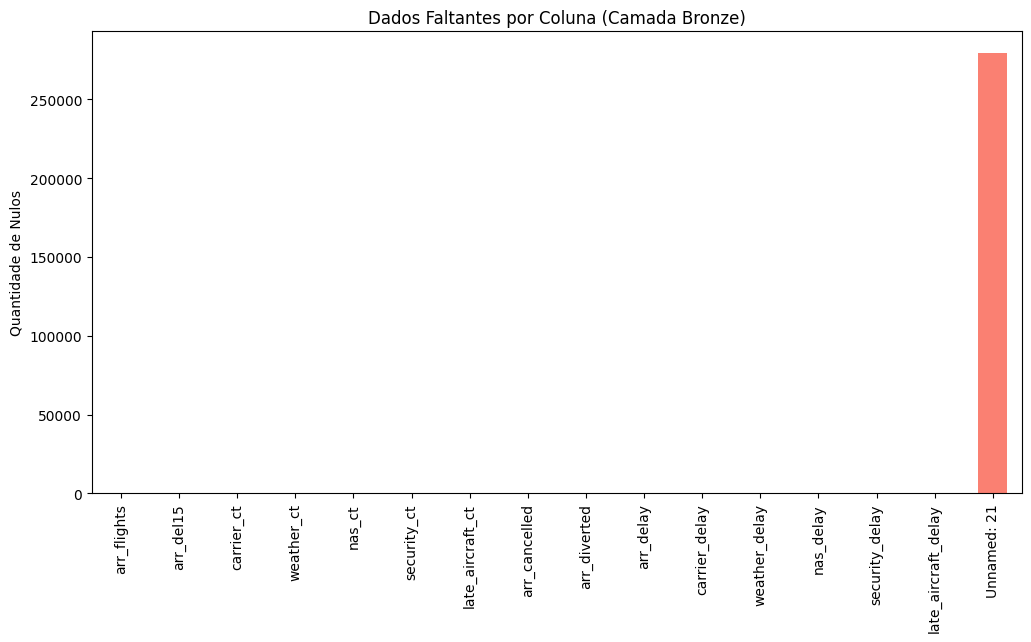

Total de linhas com valores nulos: 279182


In [ ]:
nulos = df.isnull().sum()

# Gráfico de barras para visualizar falhas nos dados
plt.figure(figsize=(12, 6))
nulos[nulos > 0].plot(kind='bar', color='salmon')
plt.title('Dados Faltantes por Coluna (Camada Bronze)')
plt.ylabel('Quantidade de Nulos')
plt.show()

print(f"Total de linhas com valores nulos: {df.isnull().any(axis=1).sum()}")


# 2.Verificação de Registros Duplicados

**Gráfico:**Barras

**Finalidade:** Identificar se há redundância no CSV original(Linhas duplicadas).

**Importância para o ETL:** A existência de duplicados na camada Bronze pode gerar métricas infladas no Dashboard final. O ETL de Raw to Silver será responsável por "limpar esses dados", logo precisamos verificar.

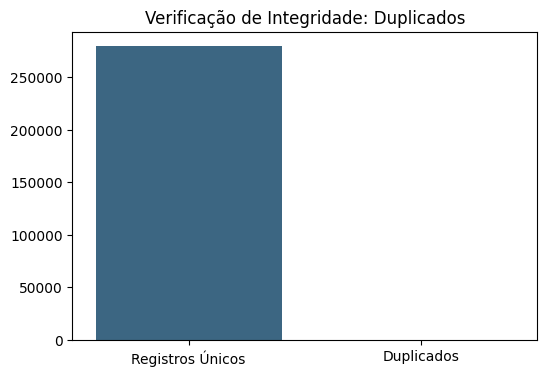

Foram encontrados 0 registros duplicados.


In [3]:
total_duplicados = df.duplicated().sum()

# Representação visual simples
plt.figure(figsize=(6, 4))
nomes = ['Registros Únicos', 'Duplicados']
valores = [len(df) - total_duplicados, total_duplicados]

sns.barplot(x=nomes, y=valores, hue=nomes, palette='viridis', legend=False)
plt.title('Verificação de Integridade: Duplicados')
plt.show()

print(f"Foram encontrados {total_duplicados} registros duplicados.")


# 3.Verificar Outliers

3. Identificação de Outliers (Dados Fora da Curva)

**Gráfico:** Box Plot.

**Finalidade**: Detectar valores extremos (como os atrasos superiores a 400.000 minutos observados) para avaliar se são erros de entrada de dados ou eventos reais de cauda longa.

**Importância para o ETL:** Identificar se há algum dado muito discrepante que possa comprometer nossos dashboards na camada **gold**, por exemplo.

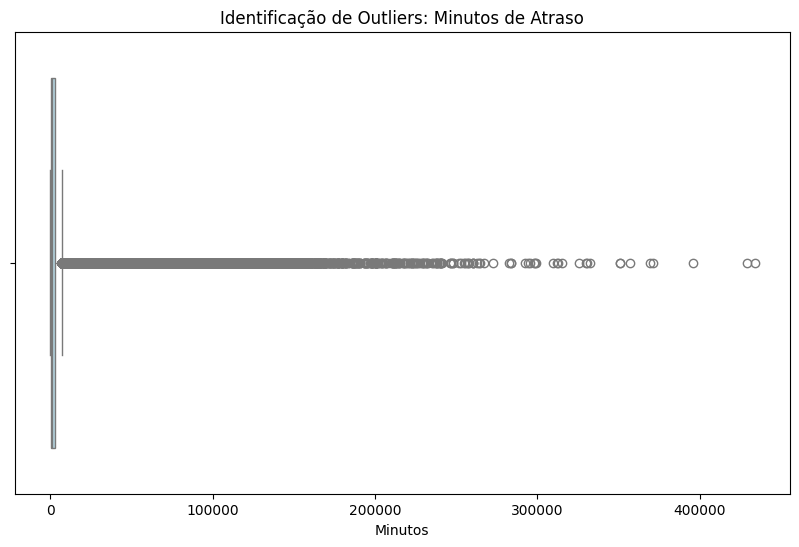

In [4]:
# Analisando outliers na coluna de atraso total
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['arr_delay'], color='lightblue')
plt.title('Identificação de Outliers: Minutos de Atraso')
plt.xlabel('Minutos')
plt.show()

## 4. Análise de Distribuição (Histograma)

**Gráfico**: Histograma.

**Finalidade:** Visualizar a concentração do volume de voos (`arr_flights`) por registro.

**Importância para o ETL:** Identificar se a maioria dos registros representa aeroportos de pequeno, médio ou grande porte, o que auxilia na definição de estratégias de particionamento na camada **Gold**.


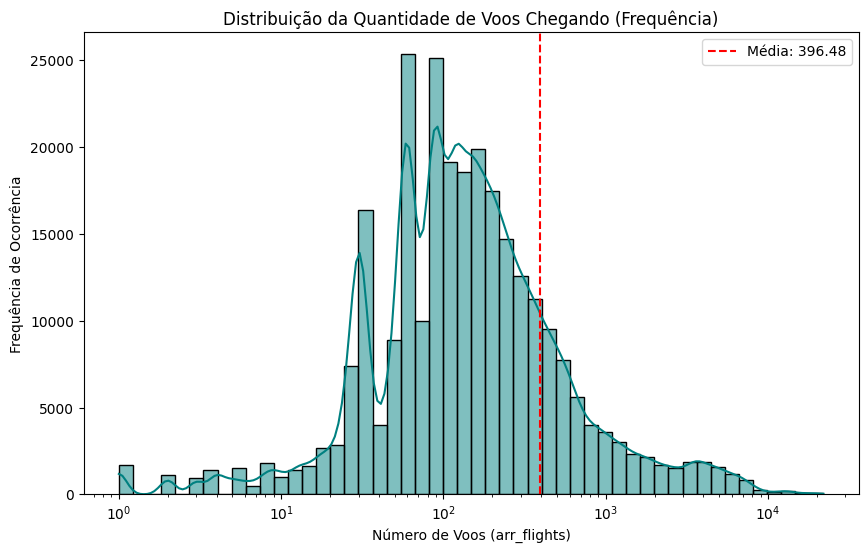

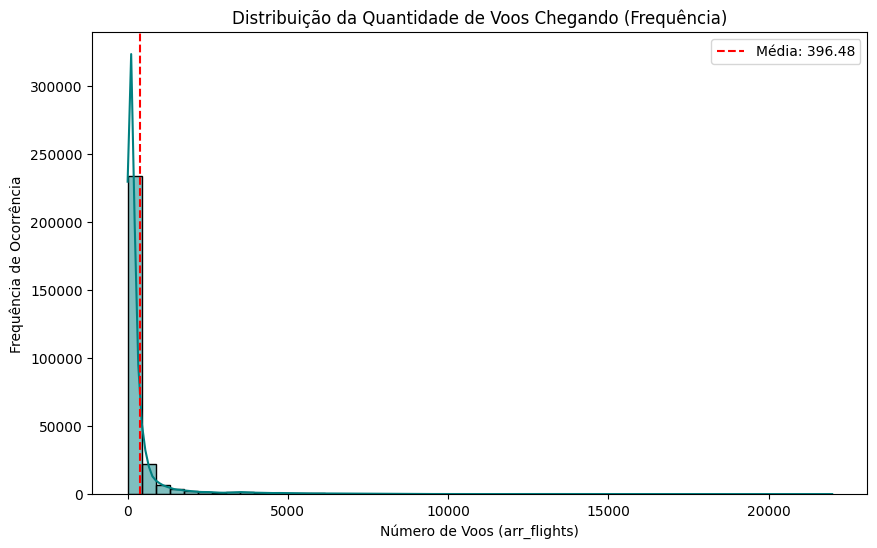

In [ ]:
plt.figure(figsize=(10, 6))

# Criando o histograma para a coluna de quantidade de voos
sns.histplot(df['arr_flights'].dropna(), bins=50, kde=True, color='teal',log_scale=True)

plt.title('Distribuição da Quantidade de Voos Chegando (Frequência)')
plt.xlabel('Número de Voos (arr_flights)')
plt.ylabel('Frequência de Ocorrência')

# Adicionando uma linha para a média, facilitando a análise estatística
plt.axvline(df['arr_flights'].mean(), color='red', linestyle='--', label=f'Média: {df["arr_flights"].mean():.2f}')
plt.legend()

plt.show()

plt.figure(figsize=(10, 6))

# Criando o histograma para a coluna de quantidade de voos(Linear)
sns.histplot(df['arr_flights'].dropna(), bins=50, kde=True, color='teal')

plt.title('Distribuição da Quantidade de Voos Chegando (Frequência)')
plt.xlabel('Número de Voos (arr_flights)')
plt.ylabel('Frequência de Ocorrência')

plt.axvline(df['arr_flights'].mean(), color='red', linestyle='--', label=f'Média: {df["arr_flights"].mean():.2f}')
plt.legend()

plt.show()



## 5. Análise da Correlação de Atrasos

**Gráfico**: matriz de correlação.

**Finalidade:** Visualizar quais colunas se relacionam mais para causar atrasos.

**Importância para o ETL:** Servirá para comparar essa métrica de causa de atraso entre o dado sujo (raw) e o dado limpo na silver.


In [ ]:
# Matriz de correlação e heatmap
if len(numeric_cols) >= 2:
    # Calcular correlação
    corr_matrix = df[numeric_cols].corr()
    
    # Plotar heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Máscara para mostrar apenas triângulo inferior
    
    sns.heatmap(
        corr_matrix,
        mask=mask,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        center=0,1. Cálculo da Matriz de Correlação

O código utiliza o método de Pearson (padrão do Pandas) para calcular a força da relação entre os pares de colunas.

    Intervalo: Os valores variam de -1.0 (correlação negativa perfeita) a 1.0 (correlação positiva perfeita).

    O valor 0 indica que não há relação linear entre as variáveis.
        square=True,
        linewidths=1,
        cbar_kws={"shrink": 0.8},
        vmin=-1,
        vmax=1
    )
    
    plt.title('Matriz de Correlação - Variáveis Numéricas', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # Identificar correlações mais fortes (excluindo diagonal)
    print("=" * 80)
    print("TOP 10 CORRELAÇÕES MAIS FORTES (em valor absoluto)")
    print("=" * 80)
    
    # Criar DataFrame com pares de correlação
    corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            corr_value = corr_matrix.iloc[i, j]
            if not np.isnan(corr_value):
                corr_pairs.append({
                    'Variável_1': col1,
                    'Variável_2': col2,
                    'Correlação': corr_value,
                    'Abs_Correlação': abs(corr_value)
                })
    
    if corr_pairs:
        corr_df = pd.DataFrame(corr_pairs).sort_values('Abs_Correlação', ascending=False).head(10)
        display(corr_df)
    else:
        print("Nenhuma correlação válida encontrada.")
    
    print(f"\n✓ Heatmap de correlação gerado para {len(numeric_cols)} variáveis numéricas")
else:
    print(f"Número insuficiente de variáveis numéricas ({len(numeric_cols)}) para análise de correlação. Necessário ≥ 2.")